# Which Neighborhood in Pittsburgh is Bussin'?
## By Large Thoughts (Griffin Hurt and Brandon Moretti)

![A PRT bus swallowed by the city it once loved.](https://pbs.twimg.com/media/EH91yHrXkAM2Yd1?format=jpg&name=small)

_Hint: It's probably not the area of downtown serviced by the G31._

### Introduction

Almost every Pitt student has utilized the Pittsburgh public transit system, known as Pittsburgh Regional Transportation. There are plenty of reasons for this, ranging from lack of a car (or lack of friends who have cars), economical reasons, or eco-friendliness. However, taking the bus is often much more difficult than driving due to a lack of stops close to the intended destination, buses running behind schedule, and too many people crowding the bus. Future Pittsburgh residents or Pitt students planning to use public transportation might be interested to know which neighborhood provides the best bus experience, which is what we attempt to measure with this project. We considered including the T in this project; however, because the T only serves a select number of neighborhoods, we figured it would unfairly bias the data.

### Our Metric: Bus Effectiveness
We decided to measure the effectiveness of the bus system in each neighborhood using three metrics:
1. Number of Stops Per Neighborhood
2. Ridership for Routes in Each Neighborhood
3. On Time Percentage for Stops in Each Neighborhood



We used four different datasets for this project:
1. [List of Pittsburgh Neighborhood Boundaries](https://data.wprdc.org/dataset/neighborhoods2)
    
    This dataset contains the boundaries of each of the Pittsburgh neighborhoods so we can match each of the stops to their respective neighborhood.

2. [Pittsburgh Regional Transit Monthly Average Ridership by Route](https://data.wprdc.org/dataset/prt-monthly-average-ridership-by-route)
    
    This dataset describes the number of people that ride Pittsburgh Regional Transit organized by route.

3. [Pittsburgh Regional Transit Transit Stops](https://data.wprdc.org/dataset/prt-of-allegheny-county-transit-stops)

    This dataset provides information about bus and T stops, including location and available amenities (such as a shelter).

4. [Port Authority Monthly On Time Performance by Route](https://data.wprdc.org/dataset/port-authority-monthly-average-on-time-performance-by-route)

    This dataset details the on time percentage performance for each of the PRT routes.

### Metric #1: Number of Bus Stops by Neighborhood
#### Analyzed by Griffin Hurt

Let's get started by loading in the neighborhood data with geopandas.

In [1]:
import geopandas as gpd
import pandas as pd

# Load in the neighborhoods
neighborhood_data = gpd.read_file('data/pittsburghpaneighborhoods-/Neighborhoods_.shp')

neighborhood_data.head(3)

,OBJECTID,fid_blockg,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,...,created_us,created_da,last_edite,last_edi_1,temp,pghdb_sde_,GlobalID,Shape__Are,Shape__Len,geometry
0,1,233,42,003,140500,3,420031405003,Block Group 3,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,7968760.0,a642a6b6-a2a9-48d5-acf2-3e2ce87d4bc0,8.153647e+06,14047.065024,"POLYGON ((-79.90560 40.45522, -79.90553 40.455..."
1,2,203,42,003,140100,3,420031401003,Block Group 3,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,34078712.0,20d4605b-258e-441a-a57e-a28fdabb6d30,3.407739e+07,30347.886823,"POLYGON ((-79.91309 40.43804, -79.91321 40.438..."
2,3,86,42,003,101700,2,420031017002,Block Group 2,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,12751163.0,bf4065e7-c29c-48bd-b529-e7fd99077238,1.275116e+07,14577.441571,"POLYGON ((-79.93457 40.47217, -79.93455 40.472..."


We see that the neighborhood name is contained in the column labeled "hood" and the borders of the neighborhood are in "geometry". We can use the polygon object in "geometry" later to determine whether a bus stop is located in a neighborhood or not with `polygon.contains(stop)`.

Next we need to load in the bus stops.

In [2]:
# Load in the bus stops
stops = gpd.read_file('data/paac_stops_1909/PAAC_Stops_1909.shp')
# Filter stops to be bus stops only
stops = stops[stops["Mode"] == "Bus"]

stops.head(3)

,StopID,Stop_name,CleverID,Direction,Timepoint,Routes_ser,Routes_cou,Latitude,Longitude,Mode,Shelter,Stop_type,On_avwk_FY,Off_avwk_F,On_avwk__1,Off_avwk_1,AvgWkdy_De,geometry
0,E00175,26TH ST AT PENN AVE FS (SPRING WAY),2593.0,Inbound,N,"54, 88, 91",3.0,40.454635,-79.978170,Bus,No Shelter,Bus Stop,34.531580,43.900523,35,44,0.03,POINT (1348499.759 416298.200)
1,E00180,28TH ST AT LIBERTY AVE,2161.0,Inbound,N,54,1.0,40.456288,-79.974651,Bus,No Shelter,Bus Stop,1.304759,10.216890,1,10,0.03,POINT (1349493.900 416875.511)
2,E00270,32ND ST AT SPRING WAY,2410.0,Outbound,N,"54, 88, 91",3.0,40.460347,-79.969436,Bus,No Shelter,Bus Stop,13.184478,33.410865,13,33,0.04,POINT (1350981.820 418317.228)


It would be wonderful if the `Point` classes in the "geometry" column used latitude and longitude, but they don't, so we'll have to do that manually.

Next we're going to simplify the unwieldy geopandas dataset into a pandas dataset that is more manageable.

In [3]:

neighborhoods = pd.DataFrame(columns = ["Neighborhood", "Geometry", "Stops"])
neighborhoods["Neighborhood"] = neighborhood_data["hood"]
neighborhoods["Geometry"] = neighborhood_data["geometry"]
neighborhoods["Stops"] = 0

neighborhoods.head(3)

,Neighborhood,Geometry,Stops
0,Point Breeze North,"POLYGON ((-79.90560 40.45522, -79.90553 40.455...",0
1,Squirrel Hill North,"POLYGON ((-79.91309 40.43804, -79.91321 40.438...",0
2,Garfield,"POLYGON ((-79.93457 40.47217, -79.93455 40.472...",0


Now we're ready to iterate through the bus stops and determine how many of them are in each neighborhood.

In [4]:
# Point class so we can fix the incorrect point geometry
from shapely.geometry import Point

for i, stop in stops.iterrows():
    # First, fix the point by using the correct latitude and longitude
    pt = Point(stop["Longitude"], stop["Latitude"])
    for j, neighborhood in neighborhoods.iterrows():
        # Check if the neighborhood has the stop
        if neighborhood["Geometry"].contains(pt):
            neighborhoods.at[j, 'Stops'] = neighborhood["Stops"] + 1
            # Break to save computation time
            break

neighborhoods.head(3)

,Neighborhood,Geometry,Stops
0,Point Breeze North,"POLYGON ((-79.90560 40.45522, -79.90553 40.455...",15
1,Squirrel Hill North,"POLYGON ((-79.91309 40.43804, -79.91321 40.438...",78
2,Garfield,"POLYGON ((-79.93457 40.47217, -79.93455 40.472...",39


We can now sort the data in descending order by number of stops to see which neighborhood has the most stops.

In [5]:
neighborhoods_sorted = neighborhoods.sort_values("Stops", ascending=False)

neighborhoods_sorted.head()

,Neighborhood,Geometry,Stops
21,Lincoln-Lemington-Belmar,"MULTIPOLYGON (((-79.90496 40.48522, -79.90470 ...",95
52,Bloomfield,"POLYGON ((-79.94645 40.46547, -79.94621 40.465...",94
43,Central Business District,"POLYGON ((-79.99238 40.44484, -79.99233 40.444...",93
54,Mount Washington,"POLYGON ((-79.99927 40.42915, -79.99927 40.429...",86
75,Shadyside,"POLYGON ((-79.92238 40.46055, -79.92208 40.460...",82


We see that Lincoln-Lemington-Belmar is the neighborhood with the most bus stops. Let's plot the top 30 neighborhoods to see the distribution.

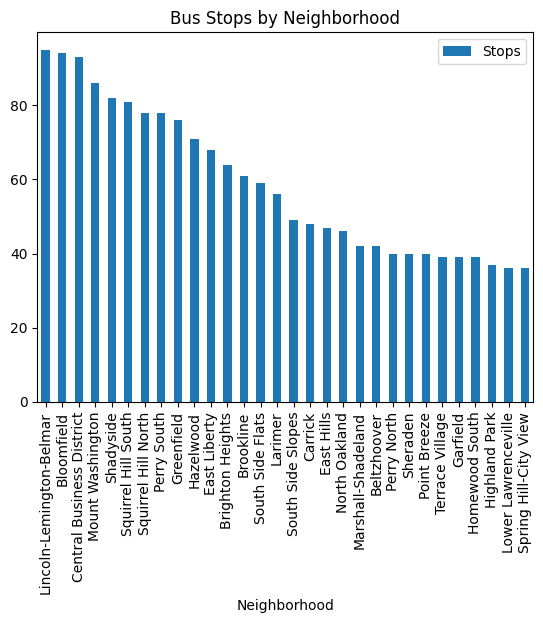

In [6]:
plt = neighborhoods_sorted.iloc[:30].plot(kind='bar', x="Neighborhood", y="Stops", title="Bus Stops by Neighborhood")

Let's also plot the bottom 30 neighborhoods.

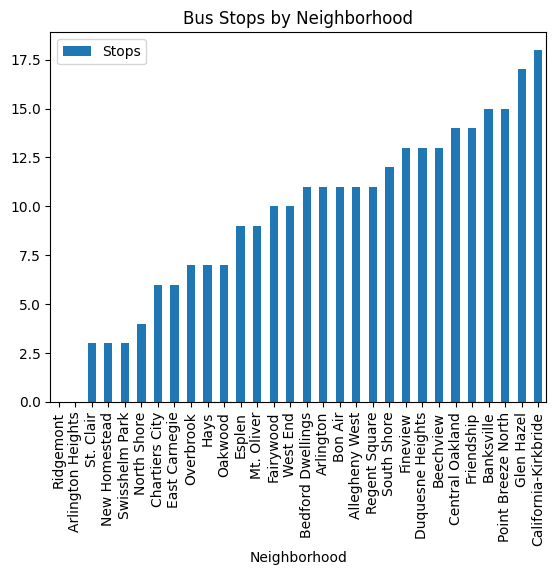

In [7]:
neighborhoods_asc = neighborhoods.sort_values("Stops")
plt2 = neighborhoods_asc.iloc[:30].plot(kind='bar', x="Neighborhood", y="Stops", title="Bus Stops by Neighborhood")

Finally, let's add bus stops to the original geodataframe and plot it.

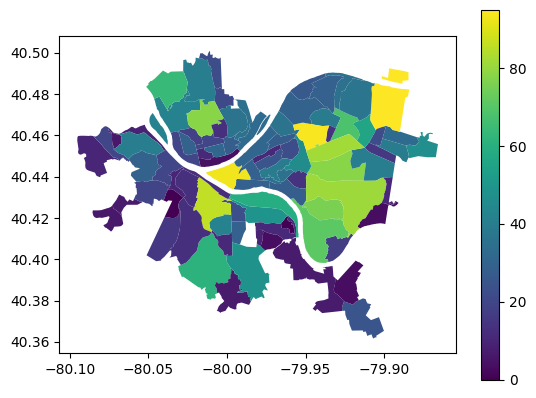

In [8]:
neighborhood_data["Bus_Stops"] = neighborhoods["Stops"]

plt3 = neighborhood_data.plot(column="Bus_Stops", legend=True)

Since we eventually want to consolidate all of the metrics into a final ranking, we create a new dataframe and save the ranks for each of the neighborhoods.

In [9]:
neighborhoods_final = pd.DataFrame()
neighborhoods_final["Name"] = neighborhoods_sorted["Neighborhood"]
# Create ranks for each of the metrics
neighborhoods_final["Stops_Rank"] = 0
neighborhoods_final["Ridership_Rank"] = 0
neighborhoods_final["OTP_Rank"] = 0

rank = 1
for index, neighborhood in neighborhoods_sorted.iterrows():
    neighborhoods_final.loc[neighborhoods_final["Name"] == neighborhood["Neighborhood"], "Stops_Rank"] = rank
    rank += 1

neighborhoods_final.sort_values("Stops_Rank").head()


,Name,Stops_Rank,Ridership_Rank,OTP_Rank
21,Lincoln-Lemington-Belmar,1,0,0
52,Bloomfield,2,0,0
43,Central Business District,3,0,0
54,Mount Washington,4,0,0
75,Shadyside,5,0,0


### Metric #2: Ridership by Neighborhood
#### Analyzed by Brandon Moretti



Here's some code that Griffin and I wrote together in order to match each of the bus routes to the neighborhoods they serve.

In [10]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Load in the neighborhoods
neighborhood_gpd = gpd.read_file('data/pittsburghpaneighborhoods-/Neighborhoods_.shp')
# Load in the bus stops
stops = gpd.read_file('data/paac_stops_1909/PAAC_Stops_1909.shp')
# Filter to only bus stops
stops = stops[stops['Mode'] == "Bus"]

# Our goal is to figure out which routes run through each neighborhood, so create a dataframe
neighborhoods = pd.DataFrame(columns=["Name", "Polygon", "Routes"])
neighborhoods["Name"] = neighborhood_gpd["hood"]
neighborhoods["Polygon"] = neighborhood_gpd["geometry"]
neighborhoods["Routes"] = [[] for _ in range(len(neighborhoods))]

for index, stop in stops.iterrows():
    # Create a point for the stop
    stop_point = Point(stop["Longitude"], stop["Latitude"])
    routes = stop["Routes_ser"].split(", ")
    # Loop through the neighborhoods
    for index2, neighborhood in neighborhoods.iterrows():
        if neighborhood["Polygon"].contains(stop_point):
            for route in routes:
                if route not in neighborhoods.at[index2, 'Routes']:
                    neighborhoods.at[index2, 'Routes'].append(route)
            break

neighborhoods.head(10)


,Name,Polygon,Routes
0,Point Breeze North,"POLYGON ((-79.90560 40.45522, -79.90553 40.455...","[71D, 28X, 88, 74, 71C, 67, 69]"
1,Squirrel Hill North,"POLYGON ((-79.91309 40.43804, -79.91321 40.438...","[58, 71B, 71D, 28X, 64, 67, 69, 61A, 61B, 61C,..."
2,Garfield,"POLYGON ((-79.93457 40.47217, -79.93455 40.472...","[89, 71A, 87, 88]"
3,Bedford Dwellings,"POLYGON ((-79.96601 40.45520, -79.96596 40.454...",[83]
4,Knoxville,"POLYGON ((-79.98845 40.41851, -79.98821 40.418...","[54, 44, 51, 51L]"
5,Homewood South,"POLYGON ((-79.88666 40.45521, -79.88651 40.455...","[77, 86, 71D, 74]"
6,Middle Hill,"POLYGON ((-79.96534 40.44994, -79.96524 40.449...","[82, 81, 83]"
7,Oakwood,"POLYGON ((-80.06322 40.42788, -80.06322 40.427...",[31]
8,North Oakland,"POLYGON ((-79.94969 40.45259, -79.94969 40.452...","[54, 71A, 71B, 71C, 71D, 75, 93, P3, 28X, 58, ..."
9,Duquesne Heights,"POLYGON ((-80.01774 40.43972, -80.01783 40.439...",[40]


Let's take a look at the ridership dataset.

In [11]:
import geopandas as gpd
import pandas as pd

# Load in the ridership
ridership = pd.read_csv('data/prt_ridership.csv')
ridership.head()


,route,ridership_route_code,route_full_name,current_garage,mode,month_start,year_month,day_type,avg_riders,day_count
0,1,001,1 - FREEPORT ROAD,Ross,Bus,2017-01-01,201701,SAT.,969.50,4
1,4,004,4 - TROY HILL,Ross,Bus,2017-01-01,201701,SAT.,218.25,4
2,6,006,6 - SPRING HILL,Ross,Bus,2017-01-01,201701,SAT.,495.50,4
3,8,008,8 - PERRYSVILLE,Ross,Bus,2017-01-01,201701,SAT.,1480.00,4
4,11,011,11 - FINEVIEW,Ross,Bus,2017-01-01,201701,SAT.,208.00,4


Let's filter the data to just be from the most recently recorded month.

In [12]:
## New data frame showing ridership only from the most recently recorded month
ridershipRecent = ridership[ridership["month_start"] == "2022-10-01"]
ridershipRecent.head()

,route,ridership_route_code,route_full_name,current_garage,mode,month_start,year_month,day_type,avg_riders,day_count
16246,1,NaN,1 - FREEPORT ROAD,Ross,Bus,2022-10-01,202210,SAT.,1181.8,5
16247,11,NaN,11 - FINEVIEW,Ross,Bus,2022-10-01,202210,SAT.,175.8,5
16248,12,NaN,12 - MCKNIGHT,Ross,Bus,2022-10-01,202210,SAT.,1235.8,5
16249,13,NaN,13 - BELLEVUE,Ross,Bus,2022-10-01,202210,SAT.,1054.4,5
16250,14,NaN,14 - OHIO VALLEY,Ross,Bus,2022-10-01,202210,SAT.,449.6,5


#### Ridership
**What do we mean by this and how are we calculating it?**

Ridership is how we are guaging how populated the bussing system is in each neighborhood. How this is being calculated is by first using each neighborhood's list of bus routes, these being the bus routes that simply pass through these neighborhoods. Now to clear this up, each bus route in the data set has a value for average riders on a general weekday, a saturday, and a sunday. So this calculation is not exactly the average weekly ridership of each route, but when we ultimately add these three values together, it gives us a good score for that route. 

Now back to the process, we go through each route in that list of routes that pass through the given neighborhood, come out with that "score" that I just talked about, and then it gets added to a total ridership for that neighborhood. Once the program has finished calculating the score for each route in that neighborhood, we are left with a total index for that neighborhood.

In [13]:
## New column called "ridership"
neighborhoods["Ridership"] = 0

for index, neighborhood in neighborhoods.iterrows():
    total = 0
    for route in neighborhood["Routes"]:
        for index2, row in ridershipRecent.iterrows():
            if row["route"] == route:
                total += row["avg_riders"]
        neighborhoods.at[index, "Ridership"] = total
    
neighborhoods.head()

,Name,Polygon,Routes,Ridership
0,Point Breeze North,"POLYGON ((-79.90560 40.45522, -79.90553 40.455...","[71D, 28X, 88, 74, 71C, 67, 69]",29997.123810
1,Squirrel Hill North,"POLYGON ((-79.91309 40.43804, -79.91321 40.438...","[58, 71B, 71D, 28X, 64, 67, 69, 61A, 61B, 61C,...",68439.038095
2,Garfield,"POLYGON ((-79.93457 40.47217, -79.93455 40.472...","[89, 71A, 87, 88]",14630.323810
3,Bedford Dwellings,"POLYGON ((-79.96601 40.45520, -79.96596 40.454...",[83],3518.885714
4,Knoxville,"POLYGON ((-79.98845 40.41851, -79.98821 40.418...","[54, 44, 51, 51L]",19957.438095


Let's sort the neighborhoods by ridership.

In [14]:
neighborhoods.sort_values("Ridership")

,Name,Polygon,Routes,Ridership
18,Arlington Heights,"POLYGON ((-79.96568 40.41735, -79.96566 40.417...",[],0.000000
64,Ridgemont,"POLYGON ((-80.03431 40.43366, -80.03424 40.433...",[],0.000000
32,Allegheny West,"POLYGON ((-80.00895 40.44996, -80.00894 40.449...",[18],41.952381
82,Swisshelm Park,"POLYGON ((-79.89143 40.42685, -79.89192 40.426...","[71, P71]",303.809524
53,Banksville,"POLYGON ((-80.02969 40.42127, -80.02976 40.419...",[36],467.714286
...,...,...,...,...
77,West Oakland,"POLYGON ((-79.95744 40.44252, -79.95744 40.442...","[54, 61A, 61B, 61C, 61D, 67, 69, 71A, 71B, 71C...",107246.304762
46,Central Oakland,"POLYGON ((-79.94925 40.44135, -79.94925 40.441...","[54, 71A, 71B, 71C, 71D, 75, 93, P3, 58, 65, 2...",107355.400000
62,South Oakland,"POLYGON ((-79.95899 40.43665, -79.95887 40.436...","[54, 71A, 71B, 71C, 71D, 75, 93, P3, 58, 65, 2...",111127.361905
8,North Oakland,"POLYGON ((-79.94969 40.45259, -79.94969 40.452...","[54, 71A, 71B, 71C, 71D, 75, 93, P3, 28X, 58, ...",116703.019048


Plotting five neighborhoods with the least ridership.

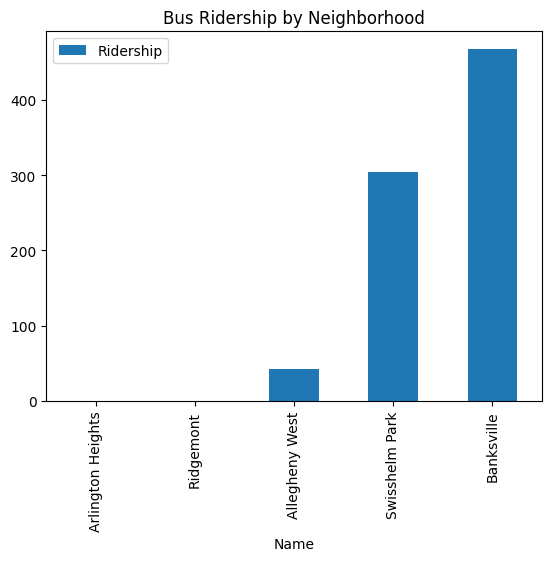

In [15]:
neighborhoods_sorted = neighborhoods.sort_values("Ridership", ascending=True)

plt = neighborhoods_sorted.head().plot(kind="bar", x="Name", title="Bus Ridership by Neighborhood")

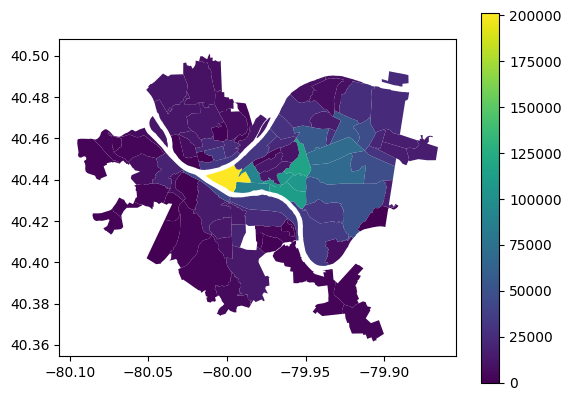

In [16]:
neighborhood_gpd["Ridership"] = 0
for index, neighborhood in neighborhoods.iterrows():
    neighborhood_gpd.loc[neighborhood_gpd["hood"] == neighborhood["Name"], "Ridership"] = neighborhood["Ridership"]

plt = neighborhood_gpd.plot(column="Ridership", legend=True)

Let's add the ranks to the final dataframe and see where we stand.

In [17]:
rank = 1
for index, neighborhood in neighborhoods_sorted.iterrows():
    neighborhoods_final.loc[neighborhoods_final["Name"] == neighborhood["Name"], "Ridership_Rank"] = rank
    rank += 1

neighborhoods_final.sort_values("Ridership_Rank").head()

,Name,Stops_Rank,Ridership_Rank,OTP_Rank
18,Arlington Heights,90,1,0
64,Ridgemont,89,2,0
32,Allegheny West,71,3,0
82,Swisshelm Park,86,4,0
53,Banksville,64,5,0


### Metric #3: On Time Percentage by Neighborhood
#### Analyzed by Griffin Hurt

To quantify the on time percentage for a neighborhood, we want to look at the stops in that neighborhood concurrently with the on time percentage for the routes that run on those stops.

We first have to load in the on time percentage data.

In [18]:
otp_data = pd.read_csv("data/OTP_data.csv")

otp_data.head(5)

,route,ridership_route_code,route_full_name,current_garage,mode,month_start,year_month,day_type,on_time_percent,data_source
0,1,001,1 - FREEPORT ROAD,Ross,Bus,2017-01-01,201701,WEEKDAY,0.6837,Clever
1,1,001,1 - FREEPORT ROAD,Ross,Bus,2017-01-01,201701,SAT.,0.6977,Clever
2,1,001,1 - FREEPORT ROAD,Ross,Bus,2017-01-01,201701,SUN.,0.6280,Clever
3,2,002,2 - MOUNT ROYAL,Ross,Bus,2017-01-01,201701,WEEKDAY,0.6978,Clever
4,4,004,4 - TROY HILL,Ross,Bus,2017-01-01,201701,WEEKDAY,0.7438,Clever


We want to consolidate the data for each route, so we will create a new dataframe with all the routes and their overall average on time percentage.

In [19]:
# BLLB, BLSV, RED, BLUE, and SLVR are T lines, so exclude
excluded_routes = ["BLLB", "BLSV", "RED", "BLUE", "SLVR", float("NaN")]
otp_bus = otp_data.query("route not in @excluded_routes")
# Get all the unique route identifiers
route_identifiers = otp_bus.route.unique()
# Create a new pandas dataset for those routes and their on time percentages
otp_routes = pd.DataFrame(columns=["Route", "OTP_Sum", "OTP_Num_Obs"])
otp_routes["Route"] = route_identifiers
otp_routes["OTP_Sum"] = 0
otp_routes["OTP_Num_Obs"] = 0

for index, datapoint in otp_bus.iterrows():
    otp_routes.loc[otp_routes['Route'] == datapoint["route"], "OTP_Sum"] += datapoint["on_time_percent"]
    otp_routes.loc[otp_routes['Route'] == datapoint["route"], "OTP_Num_Obs"] += 1

# Calculate the average
otp_routes['OTP_Avg'] = otp_routes.apply(lambda row: row["OTP_Sum"] / row["OTP_Num_Obs"], axis=1)

otp_routes.head()


,Route,OTP_Sum,OTP_Num_Obs,OTP_Avg
0,1,124.6103,205,0.607855
1,2,78.7444,145,0.543065
2,4,107.5306,166,0.647775
3,6,151.8986,205,0.740969
4,7,50.9130,98,0.519520


Let's look at the best routes by average on time percentage.

In [20]:
otp_routes_sorted = otp_routes.sort_values("OTP_Avg", ascending=False)
otp_routes_sorted.head(5)

,Route,OTP_Sum,OTP_Num_Obs,OTP_Avg
72,G2,165.6887,205,0.808238
78,P1,165.2207,205,0.805955
19,26,159.4990,199,0.801503
20,27,156.9995,199,0.788942
27,40,154.6111,199,0.776940


Now we have to determine which routes pass through each neighborhood.

Brandon and I worked together on code that assigns each of the bus stops to a neighborhood. However, I made a slight change to this version so that if there are multiple stops in a neighborhood for a given route, the route is counted multiple times. That way, we can take a weighted average for the OTP of a neighborhood based on route frequency.

In [21]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Load in the neighborhoods
neighborhood_gpd = gpd.read_file('data/pittsburghpaneighborhoods-/Neighborhoods_.shp')
# Load in the bus stops
stops = gpd.read_file('data/paac_stops_1909/PAAC_Stops_1909.shp')
# Filter to only bus stops
stops = stops[stops['Mode'] == "Bus"]

# Our goal is to figure out which routes run through each neighborhood, so create a dataframe
neighborhoods = pd.DataFrame(columns=["Name", "Polygon", "Routes"])
neighborhoods["Name"] = neighborhood_gpd["hood"]
neighborhoods["Polygon"] = neighborhood_gpd["geometry"]
neighborhoods["Routes"] = [[] for _ in range(len(neighborhoods))]

for index, stop in stops.iterrows():
    # Create a point for the stop
    stop_point = Point(stop["Longitude"], stop["Latitude"])
    routes = stop["Routes_ser"].split(", ")
    # Loop through the neighborhoods
    for index2, neighborhood in neighborhoods.iterrows():
        if neighborhood["Polygon"].contains(stop_point):
            for route in routes:
                neighborhoods.at[index2, 'Routes'].append(route)
            break

neighborhoods.head(10)

,Name,Polygon,Routes
0,Point Breeze North,"POLYGON ((-79.90560 40.45522, -79.90553 40.455...","[71D, 28X, 71D, 88, 74, 74, 74, 71C, 67, 69, 7..."
1,Squirrel Hill North,"POLYGON ((-79.91309 40.43804, -79.91321 40.438...","[58, 71B, 71D, 28X, 71B, 71D, 28X, 64, 71D, 28..."
2,Garfield,"POLYGON ((-79.93457 40.47217, -79.93455 40.472...","[89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 8..."
3,Bedford Dwellings,"POLYGON ((-79.96601 40.45520, -79.96596 40.454...","[83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83]"
4,Knoxville,"POLYGON ((-79.98845 40.41851, -79.98821 40.418...","[54, 44, 54, 54, 54, 54, 44, 54, 54, 51, 54, 5..."
5,Homewood South,"POLYGON ((-79.88666 40.45521, -79.88651 40.455...","[77, 86, 77, 86, 77, 86, 77, 86, 77, 86, 77, 8..."
6,Middle Hill,"POLYGON ((-79.96534 40.44994, -79.96524 40.449...","[82, 81, 82, 81, 82, 81, 82, 81, 82, 82, 82, 8..."
7,Oakwood,"POLYGON ((-80.06322 40.42788, -80.06322 40.427...","[31, 31, 31, 31, 31, 31, 31]"
8,North Oakland,"POLYGON ((-79.94969 40.45259, -79.94969 40.452...","[54, 71A, 71B, 71C, 71D, 75, 93, P3, 54, 71A, ..."
9,Duquesne Heights,"POLYGON ((-80.01774 40.43972, -80.01783 40.439...","[40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 4..."


Next, we want to calculate the on time percentage for each of the neighborhoods based on the routes that serve them.

In [22]:
neighborhoods["OTP_Sum"] = 0.0
neighborhoods["OTP_Count"] = 0

for i, neighborhood in neighborhoods.iterrows():
    for route in neighborhood["Routes"]:
        # Adds the route OTP to the average
        try:
            as_float = float(otp_routes.loc[otp_routes["Route"] == route, "OTP_Avg"])
            neighborhoods.at[i, "OTP_Sum"] += as_float
            neighborhoods.at[i, "OTP_Count"] += 1
        except:
            # In the case that this route is not present in the dataset, ignore it
            pass

# Calculate the average on time percentage
neighborhoods['OTP_Avg'] = neighborhoods.apply(lambda row: (row["OTP_Sum"] / row["OTP_Count"]) if row["OTP_Count"] != 0 else 0, axis=1)

neighborhoods.head(10)

,Name,Polygon,Routes,OTP_Sum,OTP_Count,OTP_Avg
0,Point Breeze North,"POLYGON ((-79.90560 40.45522, -79.90553 40.455...","[71D, 28X, 71D, 88, 74, 74, 74, 71C, 67, 69, 7...",19.738214,31,0.636717
1,Squirrel Hill North,"POLYGON ((-79.91309 40.43804, -79.91321 40.438...","[58, 71B, 71D, 28X, 71B, 71D, 28X, 64, 71D, 28...",126.007377,192,0.656288
2,Garfield,"POLYGON ((-79.93457 40.47217, -79.93455 40.472...","[89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 8...",31.814873,44,0.723065
3,Bedford Dwellings,"POLYGON ((-79.96601 40.45520, -79.96596 40.454...","[83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83]",7.419210,11,0.674474
4,Knoxville,"POLYGON ((-79.98845 40.41851, -79.98821 40.418...","[54, 44, 54, 54, 54, 54, 44, 54, 54, 51, 54, 5...",25.269257,37,0.682953
5,Homewood South,"POLYGON ((-79.88666 40.45521, -79.88651 40.455...","[77, 86, 77, 86, 77, 86, 77, 86, 77, 86, 77, 8...",31.514936,49,0.643162
6,Middle Hill,"POLYGON ((-79.96534 40.44994, -79.96524 40.449...","[82, 81, 82, 81, 82, 81, 82, 81, 82, 82, 82, 8...",19.642823,30,0.654761
7,Oakwood,"POLYGON ((-80.06322 40.42788, -80.06322 40.427...","[31, 31, 31, 31, 31, 31, 31]",4.620841,7,0.660120
8,North Oakland,"POLYGON ((-79.94969 40.45259, -79.94969 40.452...","[54, 71A, 71B, 71C, 71D, 75, 93, P3, 54, 71A, ...",125.124715,194,0.644973
9,Duquesne Heights,"POLYGON ((-80.01774 40.43972, -80.01783 40.439...","[40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 4...",10.100223,13,0.776940


Let's sort the data and plot the top 30 neighborhoods.

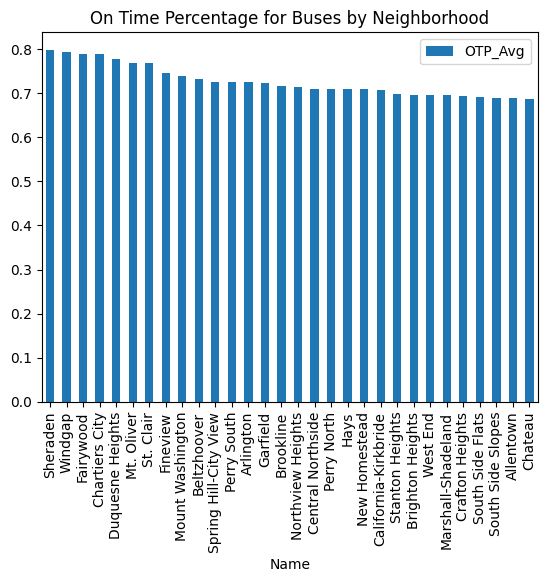

In [23]:
neighborhoods_sorted = neighborhoods.sort_values("OTP_Avg", ascending=False)

plt = neighborhoods_sorted.iloc[:30].plot(kind='bar', x="Name", y="OTP_Avg", title="On Time Percentage for Buses by Neighborhood")

Now let's look at the bottom 30 neighborhoods.

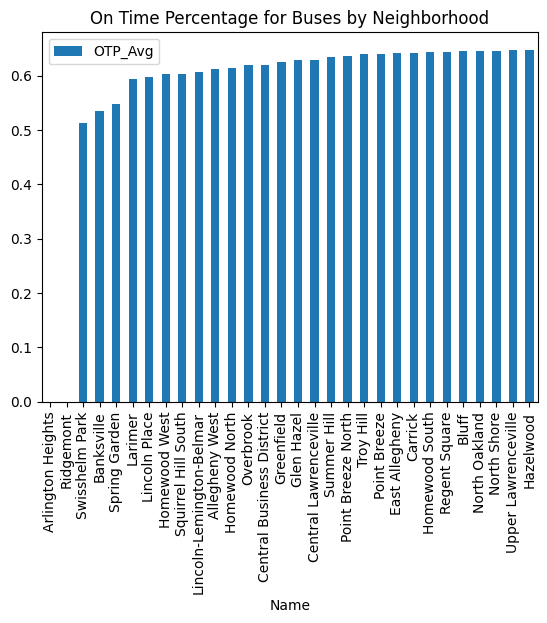

In [24]:
neighborhoods_sorted_asc = neighborhoods.sort_values("OTP_Avg")

plt2 = neighborhoods_sorted_asc.iloc[:30].plot(kind='bar', x="Name", y="OTP_Avg", title="On Time Percentage for Buses by Neighborhood")

Finally, let's plot the data on the map.

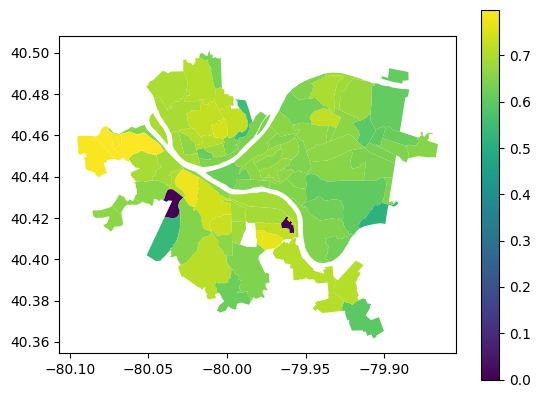

In [25]:
neighborhood_data["OTP_Avg"] = neighborhoods["OTP_Avg"]

plt3 = neighborhood_data.plot(column="OTP_Avg", legend=True)

Let's add the rankings to the final neighborhoods dataframe.

In [26]:
rank = 1
for index, neighborhood in neighborhoods_sorted.iterrows():
    neighborhoods_final.loc[neighborhoods_final["Name"] == neighborhood["Name"], "OTP_Rank"] = rank
    rank += 1

neighborhoods_final.sort_values("OTP_Rank").head()

,Name,Stops_Rank,Ridership_Rank,OTP_Rank
70,Sheraden,23,22,1
78,Windgap,59,21,2
23,Fairywood,77,12,3
50,Chartiers City,84,13,4
9,Duquesne Heights,68,6,5


### Metric Consolidation: Rank Addition Rating (RAR)

To determine the overall best neighborhood in terms of bus service, we have to combine all three datapoints. Given that the metrics are all on different scales, we determined the easiest way to combine them would be to add the ranks of every datapoint for each neighborhood such that the neighborhood with the smallest sum of ranks is then the best overall neighborhood. I like to call this "Ranked Addition Rating," or RAR.

In [27]:
# Calculate the RAR for each neighborhood

neighborhoods_final["RAR"] = neighborhoods_final.apply(lambda row: row["Stops_Rank"] + row["Ridership_Rank"] + row["OTP_Rank"], axis=1)

neighborhoods_final.head()

,Name,Stops_Rank,Ridership_Rank,OTP_Rank,RAR
21,Lincoln-Lemington-Belmar,1,64,81,146
52,Bloomfield,2,81,40,123
43,Central Business District,3,90,77,170
54,Mount Washington,4,51,9,64
75,Shadyside,5,83,41,129


Now for the moment of truth... Let's sort ascending by RAR and print the top 10 neighborhoods.

In [28]:
neighborhoods_final.sort_values("RAR").head(10)

,Name,Stops_Rank,Ridership_Rank,OTP_Rank,RAR
24,Brookline,13,16,15,44
70,Sheraden,23,22,1,46
54,Mount Washington,4,51,9,64
83,Perry South,8,45,12,65
69,Spring Hill-City View,30,31,11,72
26,Beltzhoover,21,44,10,75
47,Brighton Heights,12,42,23,77
15,Perry North,22,38,18,78
9,Duquesne Heights,68,6,5,79
89,Fineview,67,7,8,82


#### The final best neighborhood is Brookline!

Let's put this data on the map to visualize how each neighborhood did. Remember that smaller RAR values are better.

<AxesSubplot: >

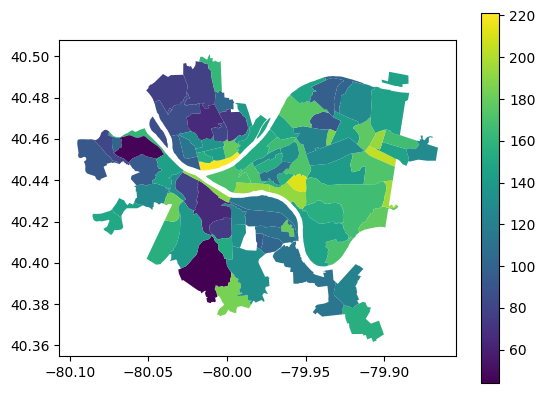

In [29]:
# Load in the neighborhoods again for assurance
neighborhood_gpd = gpd.read_file('data/pittsburghpaneighborhoods-/Neighborhoods_.shp')

neighborhood_gpd["RAR"] = 0

# Loop through each neighborhood to match the two dataframes
for index, neighborhood in neighborhoods_final.iterrows():
    neighborhood_gpd.loc[neighborhood_gpd["hood"] == neighborhood["Name"], "RAR"] = neighborhood["RAR"]

neighborhood_gpd.plot(column="RAR", legend=True)

### Conclusion

**Brandon:** I will admit that I was a bit surprised with the result, because I live 45 minutes away from here and never have heard of Brookline. However, it seems to fit the perfect balance of attributes: having a low ridership that makes getting on buses stress free for residents, having a respectful amount of bus stops, and busing that is efficiently on time. I can see how places like downtown Pittsburgh and Oakland are not high on the list after having the metrics combined because surely in those busy areas, buses and bus stops alike are going to be jam-packed and buses may have a harder time being on time when in these higher traffic areas. Residents in neighborhoods like Brookline should have an efficient, stress-free way of getting buses from their neighborhood.

**Griffin:** From the final visualization, it appears that the best neighborhoods are those just outside the city. They have enough stops to provide easy access, but not too many people to make the ride crowded. I was born and raised in the South Hills, and even though my neighborhood did not have great bus access, I used to see many buses and stops in the surrounding areas. I would be interested to see how this data would change if we instead prioritized neighborhoods with high bus ridership, as bus lines with many stops and a high on time percentage generally attract more riders. No matter how you look at it, Pittsburgh Regional Transportation provides an invaluable service to the members of the Pittsburgh community, including myself.

![A PRT bus being lifted into heaven.](https://pbs.twimg.com/media/FKdsxK_XEAEinHU?format=jpg&name=small)

_Limitation of the study: Crane transportation not accounted for in the 61B on time percentage._

### Thank you!